In [1]:
import torch
from apex import amp

In [2]:
import torch.nn as nn
import torch.nn.functional as F

#from tqdm import tqdm
from tqdm.notebook import tqdm
cfg = {
    'device_ids':0,
    'batch_size':128,
    'nz':100,
    'nc':3,
    'img_size':128,
    'ngf':64,
    'ndf':64,
    'nepochs' : 100,# Number of training epochs.
    'lr' : 0.0002,# Learning rate for optimizers
    'beta1' : 0.5,# Beta1 hyperparam for Adam optimizer
    'save_epoch' : 2,
    'plot_loss_iter': 100,
    'plot_img_iter': 1000}

# create Generator 
class Generator(nn.Module):
    def __init__(self, cfg):
        super(Generator, self).__init__()
        self.layer1 = nn.ConvTranspose2d(in_channels=cfg['nz'], out_channels=cfg['ngf'] * 32,
                                         kernel_size=4, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(cfg['ngf'] * 32)
        self.layer2 = nn.ConvTranspose2d(in_channels=cfg['ngf'] * 32, out_channels=cfg['ngf'] * 16,
                                         kernel_size=4, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(cfg['ngf'] * 16)
        self.layer3 = nn.ConvTranspose2d(in_channels=cfg['ngf'] * 16, out_channels=cfg['ngf'] * 8,
                                         kernel_size=4, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(cfg['ngf'] * 8)
        self.layer4 = nn.ConvTranspose2d(in_channels=cfg['ngf'] * 8, out_channels=cfg['ngf'] * 4,
                                         kernel_size=4, stride=2, padding=1)
        self.bn4 = nn.BatchNorm2d(cfg['ngf'] * 4)
        self.layer5 = nn.ConvTranspose2d(in_channels=cfg['ngf'] * 4, out_channels=cfg['ngf'] * 2,
                                         kernel_size=4, stride=2, padding=1)
        self.bn5 = nn.BatchNorm2d(cfg['ngf'] * 2)
        self.layer6 = nn.ConvTranspose2d(in_channels=cfg['ngf'] * 2, out_channels=3,
                                         kernel_size=4, stride=2, padding=1) 
            
        
    def forward(self, x):
        x = F.leaky_relu(self.bn1(self.layer1(x)), 0.3, True)
        x = F.leaky_relu(self.bn2(self.layer2(x)), 0.3, True)
        x = F.leaky_relu(self.bn3(self.layer3(x)), 0.3, True)
        x = F.leaky_relu(self.bn4(self.layer4(x)), 0.3, True)
        x = F.leaky_relu(self.bn5(self.layer5(x)), 0.3, True)
        x = torch.tanh(self.layer6(x))
        return x
        

In [3]:
# create Discriminator
class Discriminator(nn.Module):
    def __init__(self, cfg):
        super(Discriminator, self).__init__()
        self.layer1 = nn.Conv2d(in_channels=cfg['nc'], out_channels=cfg['ndf'],
                               kernel_size=4, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(cfg['ndf'])
        self.layer2 = nn.Conv2d(in_channels=cfg['ndf'], out_channels=cfg['ndf'] * 2,
                               kernel_size=4, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(cfg['ndf'] * 2)
        self.layer3 = nn.Conv2d(in_channels=cfg['ndf'] * 2, out_channels=cfg['ndf'] * 4,
                               kernel_size=4, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(cfg['ndf'] * 4)
        self.layer4 = nn.Conv2d(in_channels=cfg['ndf'] * 4, out_channels=cfg['ndf'] * 8,
                               kernel_size=4, stride=2, padding=1)
        self.bn4 = nn.BatchNorm2d(cfg['ndf'] * 8)
        self.layer5 = nn.Conv2d(in_channels=cfg['ndf'] * 8, out_channels=cfg['ndf'] * 16,
                               kernel_size=4, stride=2, padding=1)
        self.bn5 = nn.BatchNorm2d(cfg['ndf'] * 16)
        self.layer6 = nn.Conv2d(in_channels=cfg['ndf'] * 16, out_channels=1,
                               kernel_size=4, stride=1, padding=0)
       # self.bn6 = nn.BatchNorm2d(1)
        
    def forward(self, x):  
        x = F.leaky_relu(self.bn1(self.layer1(x)), 0.3, True)
        x = F.leaky_relu(self.bn2(self.layer2(x)), 0.3, True)
        x = F.leaky_relu(self.bn3(self.layer3(x)), 0.3, True)
        x = F.leaky_relu(self.bn4(self.layer4(x)), 0.3, True)
        x = F.leaky_relu(self.bn5(self.layer5(x)), 0.3, True)
        x = self.layer6(x)
        # x = torch.sigmoid(self.layer6(x))
        
        return x

In [4]:
fixed_noise = torch.randn(1, 100, 1, 1)

In [5]:
fixed_noise.shape

torch.Size([1, 100, 1, 1])

In [6]:
g = Generator(cfg)

In [7]:
o = g(fixed_noise)

In [8]:
o.shape

torch.Size([1, 3, 128, 128])

In [9]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [10]:
# create dateloadr 
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torch.utils.data import DataLoader
trms = transforms.Compose([  
    transforms.CenterCrop((cfg['img_size'], cfg['img_size'])),
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])
real_data = ImageFolder(root='C:/Users/scott/dataset/img_align_celeba', transform=trms)
#real_data = ImageFolder(root='/Users/lionl771128/Desktop/data', transform=trms)
real_dataloader = DataLoader(dataset=real_data, batch_size=cfg['batch_size'], shuffle=True, num_workers=4)

In [11]:
# create model, optimizier
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingLR
device = 'cuda:' + str(cfg['device_ids']) if torch.cuda.is_available() else 'cpu'
netG = Generator(cfg).to(device)
netG.apply(weights_init)
netD = Discriminator(cfg).to(device)
netD.apply(weights_init)
#criterion = nn.BCELoss()
criterion = nn.BCEWithLogitsLoss()
# training DCGAN by TTL
optimizerG = Adam(netG.parameters(), lr=cfg['lr'], betas=[cfg['beta1'], 0.999])
optimizerD = Adam(netD.parameters(), lr=cfg['lr']*3, betas=[cfg['beta1'], 0.999])
lr_schedulerG = CosineAnnealingLR(optimizerG, T_max=100, eta_min=0)
lr_schedulerD = CosineAnnealingLR(optimizerD, T_max=100, eta_min=0)

# apex mix precision
amp.register_float_function(torch, 'sigmoid')
amp.register_float_function(torch, 'softmax')
model_list, optimizer_list = amp.initialize([netG, netD], [optimizerG, optimizerD], opt_level='O1', num_losses=3)
netG = model_list[0]
netD = model_list[1]
optimizerG = optimizer_list[0]
optimizerD = optimizer_list[1]
#netG

Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic


In [12]:
# visualize loss & generated image
# matplotlib繪圖基本教學: https://www.zhihu.com/question/51745620
# matplotlib繪製動畫基本教學 https://blog.csdn.net/sailist/article/details/79475475
'''
matplotlib繪圖
1.建立figure
2.title命名
3.傳入要繪圖的資料 plt.plot
4.x,y軸命名
5.選擇要畫的統計圖表類型(ex. legend)
6.show
'''
import matplotlib.pyplot as plt
def plot_loss(lossG_list, lossD_list):
#     lossG_list = [1,2,3,4,5]
#     lossD_list = [5,4,3,2,1]
    loss_fig = plt.figure(figsize=(10, 5))
    plt.title('Generator & Discriminator loss per iteration')
    plt.plot(lossG_list, label='loss_G')
    plt.plot(lossD_list, label='loss_D')
    plt.xlabel('iteration')
    plt.ylabel('loss')
    plt.legend()
    plt.savefig('loss_record.jpg')
    #plt.show()


'''
matplotlib繪製動圖

'''
import matplotlib.animation as animation
import numpy as np
def plot_generated_image(imgs, idx):
    fig = plt.figure(figsize=(8, 8))
    plt.axis('off')
    ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in imgs]
    Writer = animation.writers['imagemagick']
    writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)
    anim = animation.ArtistAnimation(fig, ims, interval=1500, repeat_delay=1000, blit=True)
    #plt.show()
    anim.save(f'celeba_0-{idx}.gif', dpi=80, writer=writer)
    #anim.save(f'celeba.gif', dpi=80, writer=writer)
    
'''
將多張圖合併成一張大圖
Pytorch torchvision.utils.make_grid()用法
https://blog.csdn.net/u012343179/article/details/83007296
'''

import torchvision.utils as vutil



Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0


C:\Users\scott\Anaconda3\envs\pytorch\lib\site-packages\torch\optim\lr_scheduler.py:91: UserWarning: Seems like `optimizer.step()` has been overridden after learning rate scheduler initialization. Please, make sure to call `optimizer.step()` before `lr_scheduler.step()`. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0
Gradient overflow.  Skipping step, loss scaler 2 reducing loss scale to 32768.0
Gradient overflow.  Skipping step, loss scaler 2 reducing loss scale to 16384.0
Gradient overflow.  Skipping step, loss scaler 2 reducing loss scale to 8192.0
Gradient overflow.  Skipping step, loss scaler 1 reducing loss scale to 16384.0
Gradient overflow.  Skipping step, loss scaler 1 reducing loss scale to 8192.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0
Gradient overflow.  Skipping step, loss scaler 1 reducing loss scale to 4096.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 2048.0
Gradient overflow.  Skipping step, loss scaler 1 reducing loss scale to 2048.0
Gradient overflow.  Skipping step, loss scaler 1 reducing loss scale to 1024.0
Gradient overflow.  Skipping step, loss scaler 0

C:\Users\scott\Anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\scott\Anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\scott\Anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this 

C:\Users\scott\Anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\scott\Anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 2048.0


C:\Users\scott\Anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\scott\Anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Gradient overflow.  Skipping step, loss scaler 1 reducing loss scale to 2048.0
Gradient overflow.  Skipping step, loss scaler 1 reducing loss scale to 1024.0


C:\Users\scott\Anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\scott\Anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


C:\Users\scott\Anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\scott\Anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Gradient overflow.  Skipping step, loss scaler 2 reducing loss scale to 16384.0


C:\Users\scott\Anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\scott\Anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0


C:\Users\scott\Anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\scott\Anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


Gradient overflow.  Skipping step, loss scaler 2 reducing loss scale to 16384.0


Gradient overflow.  Skipping step, loss scaler 2 reducing loss scale to 8192.0


C:\Users\scott\Anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
C:\Users\scott\Anaconda3\envs\pytorch\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\scott\Anaconda3\envs\pytorch\lib\site-packages\IPython\core\interactiveshell.py", line 3319, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-ddb9d1135a33>", line 88, in <module>
    plot_loss(lossG_list, lossD_list)
  File "<ipython-input-12-95a737bffe0e>", line 20, in plot_loss
    plt.plot(lossD_list, label='loss_D')
  File "C:\Users\scott\Anaconda3\envs\pytorch\lib\site-packages\matplotlib\pyplot.py", line 2763, in plot
    is not None else {}), **kwargs)
  File "C:\Users\scott\Anaconda3\envs\pytorch\lib\site-packages\matplotlib\axes\_axes.py", line 1649, in plot
    self.add_line(line)
  File "C:\Users\scott\Anaconda3\envs\pytorch\lib\site-packages\matplotlib\axes\_base.py", line 1850, in add_line
    self._update_line_limits(line)
  File "C:\Users\scott\Anaconda3\envs\pytorch\lib\site-packages\matplotlib\axes\_base.py", line 1872, in _update_line_limits
    path = line.get_path()
  File

KeyboardInterrupt: 

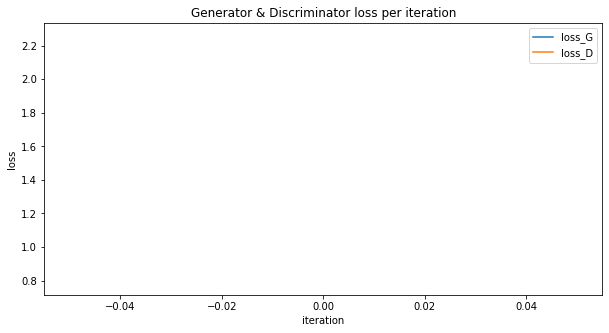

Error in callback <function flush_figures at 0x0000017D80C89378> (for post_execute):


KeyboardInterrupt: 

In [13]:
# training 
lossG_list = []
lossD_list = []
generated_imgs = []
num_epochs = cfg['nepochs']
iteration = 0
real_label = 1
fake_label = 0
fixed_noise = torch.randn(128, 100, 1, 1, device=device)
for epoch in range(num_epochs):
    with tqdm(real_dataloader, leave=False, total=len(real_dataloader)) as t:
        for idx, real_data in enumerate(t):
            # label = torch.full((cfg['batch_size'], ), real_label, device=device)
            real_data = real_data[0].to(device)
            #real_data.to(device)
           # print(real_data)
            '''
            train netD
            1. 將Discriminator梯度歸0
            2. 將real data傳入netD，計算loss(real label)和gradient
            3. 將雜訊z傳入netG生成fake data，並將fake data傳入netD，計算loss(fake label)和gradient(註)
            4. 更新參數
            (註)將fake data傳入netD時記得detach截斷這個node的gradient計算。以免計算梯度的時候將netG的節點計算進去。
            '''
        
            #1
            netD.zero_grad()

            #2
            netD.train()
            out = netD(real_data).view(-1)
            real_label = torch.ones(out.shape[0]).to(device)
            #real_label = torch.ones(1).to(device)
           # print(out.shape)
            lossD_real = criterion(out, real_label)
            with amp.scale_loss(lossD_real, optimizerD, loss_id=0) as errD_real_scaled:
                errD_real_scaled.backward()
            #lossD_real.backward()

            #3
            z = torch.randn(cfg['batch_size'], cfg['nz'], 1, 1, device=device)
            fake_data = netG(z)
            fake_label = torch.zeros(fake_data.shape[0]).to(device)
            #fake_label = torch.zeros(1).to(device)
            out = netD(fake_data.detach()).view(-1)
            lossD_fake = criterion(out, fake_label)
            with amp.scale_loss(lossD_fake, optimizerD, loss_id=1) as errD_fake_scaled:
                errD_fake_scaled.backward()
            #lossD_fake.backward()

            #4
            optimizerD.step()
            lossD = lossD_fake + lossD_real
            lossD_list.append(lossD)
                
            '''
            train netG
            1. 將Generator梯度歸0
            2. 將雜訊z傳入netG生成fake data，並將fake data傳入netD，計算loss(""real label"")和gradient(註)
            3. 更新參數
            (註)將fake data傳入netD時不需要透過detach截斷這個node的gradient計算。或是關閉netD的gradient
                因為即使計算gradient時會受D影響，但是optimizerG再刷新參數時並不會受到D的gradient影響。
                計算圖流程:
                z -> netG -> netD -> loss -> dloss/dD = dloss/dG * dG/dD
                由上方的chain rule可得知，更新netG時用的gradient並不會受到netD影響
            '''

            # 1
            netG.zero_grad()

            # 2
#             z = torch.randn(cfg['batch_size'], cfg['nz'], 1, 1, device=device)
#             fake_data = netG(z)
            real_label = torch.ones(fake_data.shape[0]).to(device)
            out = netD(fake_data).view(-1)
            lossG = criterion(out, real_label)
            with amp.scale_loss(lossG, optimizerG, loss_id=2) as errG_scaled:
                errG_scaled.backward()
            #print(lossG)
            #3
            optimizerG.step()

            lossG_list.append(lossG)

            #print(lossG_list)
           # print(lossD_list)
            if iteration % cfg['plot_loss_iter'] == 0:
                plot_loss(lossG_list, lossD_list)
                # plot_generated_image(generated_imgs)
            
            if iteration % 100 == 0:
                fake_imgs = netG(fixed_noise).detach().cpu()
                generated_imgs.append(vutil.make_grid(fake_imgs, padding=2, normalize=True))
                
            if iteration % cfg['plot_img_iter'] == 0:

                with torch.no_grad():
                    fake_imgs = netG(fixed_noise).detach().cpu()
                generated_imgs.append(vutil.make_grid(fake_imgs, padding=2, normalize=True))
                plot_generated_image(generated_imgs, iteration)
                
            iteration += 1
            lr_schedulerG.step()
            lr_schedulerD.step()